# Projet : Smart Dodger

In [1]:
import requests
import json
from pandas.io.json import json_normalize
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn import neighbors
from sklearn.preprocessing import Normalizer

# 1. Introduction

## 1.1. Contexte

League of Legends est un jeu de type MOBA (Multiplayer Online Battle Arena) où deux équipes de 5 joueurs s'affrontent.
L'objectif est d'être le premier à détruire le Nexus adverse (bâtiment principal entouré en vert ci-dessous).

<img src = "img/map_game.png" width = 600>
<center>Présentation du jeu</center>

Pour ce faire, chaque joueur se voit attribuer un rôle (généralement parmi les deux qu'il a choisi) et sélectionne un champion parmi les 148 actuellement disponibles.

<img src = "img/champion.png" width = 600>
<center>Liste non exhaustive des champions</center>

Les cinq rôles disponibles sont les suivants :


|Rôle|Lane|
|------|------|
|Toplaner|Top|
|Jungler|Jungle|
|Midlaner|Mid|
|Ad Carry|Bot/Bottom|
|Support|Bot/Bottom|

<img src = "img/map_lane.png" width = 600>
<center>Situation des rôles</center>

Ce choix de champion se fait pendant la phase de sélection des champions.

<img src = "img/champion_select.png">
<center>Phase de sélection des champions</center>

Chaque joueur dispose d'un score représentant son niveau. <br>
A l'issue de la partie, en cas de victoire, il gagne généralement entre 10 et 30 points. En cas de défaite, il les perd.

## 1.2. Problématique

Il est possible de "dodger" une partie, c'est-à-dire de refuser que la partie se lance pendant la phase de sélection des champions.

La contrepartie à cela, c'est une perte de 3 points lors du premier "dodge" sur une tranche de 16 heures, puis de 10 points sur les "dodge" suivants.

Si un joueur sent que la composition de champions de son équipe n'est pas en sa faveur, il peut décider de dodger, préférant la pénalité de points à l'optique de perdre éventuellement plus de points. (NB : d'autres facteurs peuvent entrer en compte pour décider de dodger une partie.) Il espère ainsi optimiser son score.

La problématique de mon projet est la suivante :<br>
<b>Est-il possible de prédire l'issue d'une partie en se basant uniquement sur la composition des deux équipes ?</b>



## 1.3. Métrique

Pour évaluer notre modèle, on choisira de suivre plusieurs métriques. En particulier <br>
* la précision
* un différentiel de gain espéré calculé de la façon suivante :
    * 0 point par vrai positif
    * 0 point par faux positif
    * -18 points par faux négatif
    * +12 points par vrai négatif
    
Pour expliquer ce calcul de gain, on compare les gains qu'on aurait eu sans utiliser notre prédiction avec ceux qu'on a en l'utilisant (on suppose qu'on est dans l'équipe bleue et qu'une victoire/défaite rapporte +15/-15)

<img src = "img/gain.png">


# 2. Collecte des données

## 2.1. Méthode de récolte

Pour réaliser la collecte de données, l'éditeur du jeu met à disposition une API.

L'objectif est donc de récupérer une liste de parties avec :
* la composition des équipes
* l'issue de la partie

<b>Problème :</b>

L'API ne permet pas de récupérer directement une liste de parties à partir d'appels.

<b>Solution :</b>

0. On initialise une liste d'id de compte avec l'id de compte d'un joueur.

Tant que notre liste d'id de compte n'est pas vide et qu'on n'a pas atteint le nombre limite de parties
1. On choisit un id de compte.
2. On récupère son historique de matchs.
3. On récupère les parties issues de son historique.
4. Pour chaque partie,
    * On regarde si elle est conforme (cf. 2.2.).<br>
        Si c'est le cas,
        1. On récupère les informations de la partie.
        2. On ajoute à notre liste les id de compte des autres joueurs conformes. (cf. 2.2.)
        
Le débit en mode développeur étant de 50 requêtes par minute, il m'a fallu réaliser plusieurs optimisations pour maximiser la récolte de données et rendre mon algorithme robuste à différents types d'erreur (pour éviter de devoir le relancer régulièrement). <br>
Après toutes les optimisations, je pouvais récolter jusqu'à 1 800 parties par heure.<br>
Au total, j'ai récupéré les informations de plus de 80 000 parties après 4 jours de requêtage.

## 2.2. Caractéristiques des parties

Dans la façon de constituer notre jeu de données, nous avons uniquement considéré les parties :
* classées
* du 12/01/20 au 21/01/20
* des joueurs avec un rang diamant au minimum (environ 2% des joueurs sur la période concernée)
* sur les serveurs d'Europe de l'Ouest

Ces choix ont été réalisés pour éviter des bruits dans les données.
En effet :
* les parties classées sont jouées de façon plus sérieuse avec une meilleure maitrise des champions par les joueurs.
* la plage de temps s'étale très majoritairement sur un patch (10.1).
* imposer un niveau minimum réduit vraisemblablement le phénomène de smurfing (qui consiste à créer un deuxième compte pour jouer contre des joueurs de niveau plus faible). On peut alors avoir des biais sur des champions plus "amusants" à jouer et/ou plus difficile à maitriser. Le taux de victoire de ces champions pourrait alors être artificiellement augmenté.
* utiliser les serveurs d'une même région facilite la récolte de données et évite des différences de meta (Most Effective Tactic Available) qu'il pourrait exister d'une région à une autre.

Toutefois, il est probable que le nouveau champion (Sett) engendre un biais. En effet, il y a une phase pendant laquelle les joueurs apprennent à le jouer et durant laquelle son taux de victoire a évolué sur la période observée. (Si besoin, on écartera ce champion de l'analyse.) 
<img src="img/historique_taux_de_victoire_Sett.png">
<center>Source : <a href=https://www.leagueofgraphs.com/fr/champions/stats/sett/diamond>https://www.leagueofgraphs.com/fr/champions/stats/sett/diamond</a></center>


In [ ]:
def request_main(accountIdToRequest_set, beginTime, endTime):
    """Filtre les informations nécessaires à notre analyse d'une partie
        Input :
            accountIdToRequest_set : set d'account_id à requêter
            beginTime : date de début (sélectionne les parties après cette date) - Unix timestamp en millisecondes
            endTime : date de fin (sélectionne les parties avant cette date) - Unix timestamp en millisecondes
        Output :
            Ecrit les informations des parties dans un fichier csv
    """ 
    savedRequestedAccountId_set = set()
    savedGameId_set = set()
    gameFile_csv = openOrCreateGameCsvFile(beginTime)
    numberOfGames = 0
    numberOfFailures = 0
    
    while len(accountIdToRequest_set) and numberOfGames < 10: #20000:
        print('Nombre de parties sauvegardées :',numberOfGames)
        currentAccountId = getAccountIdToRequest(accountIdToRequest_set)
        
        for attempt in range(6):
            
            try:     
                
                if checkIfAccoundIdIsConformed(currentAccountId):
                    print('Nouvel AccountId :', currentAccountId)
                    updateRequestedAccoundIdSet(currentAccountId, savedRequestedAccountId_set)
                    currentMatchHistory = getMatchHistoryFromAccountID(currentAccountId, beginTime, endTime)

                    for currentGameId in currentMatchHistory: 
                        
                        if checkIfGameIdIsNew(currentGameId, savedGameId_set):
                            currentGameInfo = requestGameInfo(currentGameId)
                            
                            if checkIfGameIsConformed(currentGameInfo):
                                currentFilteredGameInfo = filterGameInfo(currentGameInfo)
                                writeGameInfo(currentFilteredGameInfo, gameFile_csv)
                                updateSavedGameIdSet(currentGameId, savedGameId_set)
                                currentAllConformedParticipantAccoundId_list = getAllConformedParticipantAccountId(currentGameInfo)
                                updateAccountIdToRequestSet(currentAllConformedParticipantAccoundId_list, 
                                                            savedRequestedAccountId_set, 
                                                            accountIdToRequest_set)
                                print(currentGameId, "a été ajouté")
                                numberOfGames += 1
                                time.sleep(1)
                                
                            else:
                                print(currentGameId, "n'est pas conforme")
                                
                        else:
                            print(currentGameId, "n'est pas nouveau")
                            
            except:
                time.sleep(2**(attempt + 1))
                numberOfFailures += 1
                print('Erreur sur l\'accountId :',currentAccountId,
                      "Tentative n°", attempt, " (", numberOfFailures, " erreurs)")

            else:
                break
                
    gameFile_csv.close()
    print("Fin du requêtage")
    #print("Set de comptes requêtés:", savedRequestedAccountId_set)
    #print("Set de matchs requêtés:", savedGameId_set)
    #print("Set de comptes requêtables", accountIdToRequest_set)

    
#Requêtes API
def requestSummonerDataFromName(summonerName):
    """Requête les données d'un joueur à partir de son nom d'invocateur"""     
    URL = global_URL + "lol/summoner/v4/summoners/by-name/" + str(summonerName) + "?api_key=" + global_API_key
    #print (URL)
    response = requests.get(URL)
    if response.status_code != 200:
        print(response) 
    return response.json()

def requestSummonerDataFromAccountId(accountId):
    """Requête les données d'un joueur à partir de son id de compte"""    
    URL = global_URL + "lol/summoner/v4/summoners/by-account/" + str(accountId) + "?api_key=" + global_API_key
    #print (URL)
    response = requests.get(URL)
    if response.status_code != 200:
        print(response) 
    return response.json()

def requestMatchHistory(accountId, beginTime=None, endTime=None):
    """Requête l'historique d'un joueur à partir de son id de compte""" 
    if beginTime:
        URL = global_URL + "lol/match/v4/matchlists/by-account/" + str(accountId) + "?api_key=" + global_API_key + "&beginTime=" + str(beginTime) + "&endTime=" + str(endTime) + "&queue=420"      
    else:
        URL = global_URL + "lol/match/v4/matchlists/by-account/" + str(accountId) + "?api_key=" + global_API_key + "&queue=420"
    #print (URL)
    response = requests.get(URL)
    if response.status_code != 200:
        print(response) 
    return response.json() 

def requestLeagueData(accoundId):
    """Requête les données de ligue d'un joueur à partir de son id de compte""" 
    URL = global_URL + "/lol/league/v4/entries/by-summoner/" + str(accoundId) + "?api_key=" + global_API_key
    #print (URL)
    response = requests.get(URL)
    if response.status_code != 200:
        print(response) 
    return response.json()    

def requestGameInfo(gameId):
    """Requête les données d'une partie à partir de l'id de la partie""" 
    URL = global_URL + "/lol/match/v4/matches/" + str(gameId) + "?api_key=" + global_API_key
    #print (URL)
    response = requests.get(URL)
    if response.status_code != 200:
        print(response) 
    return response.json() 

#Autres fonctions
def getAccountIdToRequest(accountIdToRequest_set):   
    """Renvoie le prochain accountId à requêter et le supprime du set
        Input :
            accountIdToRequest_set : set d'accountId requêtable
        Output :    
            AccountId à requêter
    """
    return accountIdToRequest_set.pop()

def updateRequestedAccoundIdSet(accountId, savedAccountIdRequested_set):
    """Ajoute l'accoundId au set d'accountId à requêter
        Input :
            accountId : accoundId à ajouter
            savedAccountIdRequested_set : set d'accoundId
        Output :
            Aucun
    """
    savedAccountIdRequested_set.add(accountId)
    
def getMatchHistoryFromAccountID(accountId, beginTime, endTime):
    """Récupère les id de parties jouées par le joueur.
        Input : 
            beginTime : date de début (sélectionne les parties après cette date) - Unix timestamp en millisecondes
            endTime : date de fin (sélectionne les parties avant cette date) - Unix timestamp en millisecondes
        Output :
            Liste de gameId
    """
    responseMatchHistory = requestMatchHistory(accountId, beginTime, endTime)
    return [game['gameId'] for game in responseMatchHistory['matches']]

def checkIfGameIdIsNew(gameId, savedGameId_set):
    """Vérifie si le partie n'est pas déjà référencée
        Input :
            gameId : id de la partie
            savedMatchId : set de parties déjà référencées
        Output :  
            True si la partie n'est pas déjà référencée        
    """     
    return not (gameId in savedGameId_set)
    
def checkIfGameIsConformed(gameInfo):
    """Vérifie si le partie correspond à notre cahier des charges
        Input :
            gameInfo : informations de la partie
        Output :  
            True si la partie est conforme        
    """
    return gameInfo['queueId'] == 420
    

def filterGameInfo(gameInfo):
    """Filtre les informations nécessaires à notre analyse
        Input : 
            gameInfo : informations de la partie
        Output :
            Dictionnaire contenant les informations filtrées
    """        
    filteredGameInfo = {}
    filteredGameInfo['gameId'] = gameInfo['gameId']
    filteredGameInfo['team1_outcome'] = gameInfo['teams'][0]['win']
    filteredGameInfo['team1_side'] = 'blue' if gameInfo['teams'][0]['teamId'] == 100 else 'red'

    for p in range(10):
        filteredGameInfo['participant_'+ str(p + 1) + '_championId'] = gameInfo['participants'][p]['championId']
        filteredGameInfo['participant_'+ str(p + 1) + '_team'] = 'blue' if gameInfo['participants'][p]['teamId'] == 100 else 'red'
        filteredGameInfo['participant_'+ str(p + 1) + '_role'] = gameInfo['participants'][p]['timeline']['role']
        filteredGameInfo['participant_'+ str(p + 1) + '_lane'] = gameInfo['participants'][p]['timeline']['lane']    

    return filteredGameInfo

def openOrCreateGameCsvFile(beginTime):   
    """Renvoie un 'csv'
        Input :
            beginTime : date de début (sélectionne les parties après cette date) - Unix timestamp en millisecondes
        Output :
            csv
    """
    if not os.path.exists('games_'+ str(beginTime) + '.csv'):
        print('Le fichier' + 'games_'+ str(beginTime) + '.csv' + ' n\'existe pas => Création du fichier')
        gameFile_csv = open('games_'+ str(beginTime) + '.csv', 'a', newline='')
        fnames = ['gameId', 'team1_outcome', 'team1_side', 
                  'participant_1_championId', 'participant_1_team', 'participant_1_role', 'participant_1_lane', 
                  'participant_2_championId', 'participant_2_team', 'participant_2_role', 'participant_2_lane', 
                  'participant_3_championId', 'participant_3_team', 'participant_3_role', 'participant_3_lane', 
                  'participant_4_championId', 'participant_4_team', 'participant_4_role', 'participant_4_lane', 
                  'participant_5_championId', 'participant_5_team', 'participant_5_role', 'participant_5_lane', 
                  'participant_6_championId', 'participant_6_team', 'participant_6_role', 'participant_6_lane', 
                  'participant_7_championId', 'participant_7_team', 'participant_7_role', 'participant_7_lane', 
                  'participant_8_championId', 'participant_8_team', 'participant_8_role', 'participant_8_lane', 
                  'participant_9_championId', 'participant_9_team', 'participant_9_role', 'participant_9_lane', 
                  'participant_10_championId', 'participant_10_team', 'participant_10_role', 'participant_10_lane']
        writer = csv.DictWriter(gameFile_csv, fieldnames=fnames, delimiter=";")
        writer.writeheader()            
    else:
        gameFile_csv = open('games_'+ str(beginTime) + '.csv', 'a', newline='')
    return gameFile_csv

def writeGameInfo(filteredGameInfo, gameFile_csv):
    """Ajoute les informations d'une partie dans un csv
        Input :
            filteredGameInfo : information utiles d'une partie
            gameFile_csv : csv
        Output :
            Aucun
    """  
    fnames = ['gameId', 'team1_outcome', 'team1_side', 
              'participant_1_championId', 'participant_1_team', 'participant_1_role', 'participant_1_lane', 
              'participant_2_championId', 'participant_2_team', 'participant_2_role', 'participant_2_lane', 
              'participant_3_championId', 'participant_3_team', 'participant_3_role', 'participant_3_lane', 
              'participant_4_championId', 'participant_4_team', 'participant_4_role', 'participant_4_lane', 
              'participant_5_championId', 'participant_5_team', 'participant_5_role', 'participant_5_lane', 
              'participant_6_championId', 'participant_6_team', 'participant_6_role', 'participant_6_lane', 
              'participant_7_championId', 'participant_7_team', 'participant_7_role', 'participant_7_lane', 
              'participant_8_championId', 'participant_8_team', 'participant_8_role', 'participant_8_lane', 
              'participant_9_championId', 'participant_9_team', 'participant_9_role', 'participant_9_lane', 
              'participant_10_championId', 'participant_10_team', 'participant_10_role', 'participant_10_lane']
    writer = csv.DictWriter(gameFile_csv, fieldnames=fnames, delimiter=";")       
    writer.writerow(filteredGameInfo)

def getAllConformedParticipantAccountId(gameInfo):
    """Récupère la liste des joueurs conformes (ie. ceux de l'Europe de l'Ouest)
        Input :
            gameInfo : informations de la partie
        Output :    
            Liste de joueurs conformes
    """
    allConformedParticipantAccountId_list = []
    for participant in gameInfo['participantIdentities']:
        if participant['player']['platformId'] == 'EUW1':
            allConformedParticipantAccountId_list.append(participant['player']['accountId'])
    print(len(allConformedParticipantAccountId_list), "participants conformes")
    return allConformedParticipantAccountId_list
    
    
def updateSavedGameIdSet(gameId, savedGameId_set):
    """Ajoute le gameId au set de gameId déjà référencées
        Input :
            gameInfo : informations de la partie
            savedGameId_set : set de parties déjà référencées
        Output :   
            Aucun
    """
    savedGameId_set.add(gameId)    
    
def updateAccountIdToRequestSet(allConformedParticipantAccoundId_list, savedRequestedAccountId_set, accountIdToRequest_set):
    """Ajoute les id de joueurs conformes non déjà requêtés à la liste de joueurs à requêter   
        Input :
            allConformedParticipantAccoundId_list : liste d'accountId de joueurs confromes
            savedRequestedAccountId_set : set d'accountId déjà requêté
            accountIdToRequest_set : set d'accountId à requêter
        Output :    
            Aucun
    """    
    for accountId in allConformedParticipantAccoundId_list:
        if not accountId in savedRequestedAccountId_set:
            accountIdToRequest_set.add(accountId)

def checkIfAccoundIdIsConformed(accountId):
    """Vérifie si un accountId est conforme (ie. si le joueur à un niveau supérieur ou égal à diamant)
    (Remarque : on ne fusionne pas cette fonction avec getAllConformedParticipantAccountId 
    car celle-ci nécessite de réaliser deux requêtes à l'API de Riot Games)
        Input :
            accountId : id de compte du joueur
        Output :    
            True si l'accountId est conforme
    """  
    time.sleep(2.5)
    summonerData = requestSummonerDataFromAccountId(accountId)
    leagueData = requestLeagueData(summonerData['id'])
    
    i = 0
    accountIsConformed = False
    
    while i < len(leagueData) and leagueData[i]['queueType'] != 'RANKED_SOLO_5x5':
        i = i+1

    if i < len(leagueData) and leagueData[i]['queueType'] == 'RANKED_SOLO_5x5':
        print(leagueData)
        accountIsConformed = leagueData[i]['tier'] in ('DIAMOND','MASTER','GRANDMASTER','CHALLENGER')
    
    return accountIsConformed 

In [ ]:
#Initialisation
user = "[INSERT YOUR USERNAME]"
global_API_key = "[INSERT YOUR API KEY]" #Clé valide 24h
global_URL = "https://euw1.api.riotgames.com/"

beginTime = 1578960000000 - 0*86400000
endTime = beginTime + 1*86400000
accountIdToRequest_set = set()
accountIdToRequest_set.add('LKa6owd_dPLdyeGAVPjGCuWejkhe-pc2JKe67gUAJgnfbw') #Id de 'FNC MagiFelix'

#Main
request_main(accountIdToRequest_set, beginTime, endTime)

# 3. Importation des données

## 3.1. Importation des parties

In [2]:
#Remarque : lors de la récolte de données, on a généré plusieurs csv qui ont été concaténés dans un csv nommé "games.csv"
all_games_df = pd.read_csv("games.csv", delimiter = ";") .set_index("gameId")

games_df, games_test_df = train_test_split(all_games_df, random_state = 26012020, train_size = 0.8)

all_games_n = len(all_games_df)

games_n = len(games_df)

print("Nombre de parties totales :", all_games_n)
print("Nombre de parties training:", games_n)

games_df.head()

Nombre de parties totales : 86186
Nombre de parties training: 68948


,team1_outcome,team1_side,participant_1_championId,participant_1_team,participant_1_role,participant_1_lane,participant_2_championId,participant_2_team,participant_2_role,participant_2_lane,...,participant_8_role,participant_8_lane,participant_9_championId,participant_9_team,participant_9_role,participant_9_lane,participant_10_championId,participant_10_team,participant_10_role,participant_10_lane
gameId,,,,,,,,,,,,,,,,,,,,,
4372853992,Fail,blue,267,blue,DUO_SUPPORT,BOTTOM,90,blue,SOLO,MIDDLE,...,DUO_SUPPORT,BOTTOM,81,red,DUO_CARRY,BOTTOM,59,red,DUO,MIDDLE
4371569841,Win,blue,99,blue,SOLO,MIDDLE,30,blue,NONE,JUNGLE,...,SOLO,BOTTOM,111,red,NONE,JUNGLE,19,red,NONE,JUNGLE
4363305102,Win,blue,18,blue,DUO_SUPPORT,MIDDLE,98,blue,SOLO,TOP,...,DUO_SUPPORT,BOTTOM,141,red,NONE,JUNGLE,13,red,SOLO,MIDDLE
4376586295,Fail,blue,145,blue,DUO_CARRY,BOTTOM,13,blue,SOLO,MIDDLE,...,DUO_CARRY,BOTTOM,44,red,DUO_SUPPORT,BOTTOM,4,red,SOLO,MIDDLE
4372794448,Win,blue,9,blue,NONE,JUNGLE,246,blue,SOLO,MIDDLE,...,SOLO,MIDDLE,134,red,DUO_SUPPORT,BOTTOM,498,red,DUO_CARRY,BOTTOM


Après 4 jours de requêtage, on a récupéré des données sur 86 186 parties. On en utilise 80% (68948) dans notre training set.

## 3.2. Importation de la liste des champions

In [3]:
champion_data = pd.read_json("champion.json")
champion_df = json_normalize(champion_data["data"])[["key","id"]]
champion_df.columns = ["champion_key","champion_id"]
champion_df["champion_key"] = champion_df["champion_key"].astype("int64")
champion_df = champion_df.set_index("champion_key")
champion_df

C:\Users\remil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,champion_id
champion_key,
266,Aatrox
103,Ahri
84,Akali
12,Alistar
32,Amumu
...,...
238,Zed
115,Ziggs
26,Zilean


# 4. Exploration des données

## 4.1. Composition des équipes rouge et bleue et taux de victoire

In [4]:
games_df.filter(like="team").describe(include = "all")

,team1_outcome,team1_side,participant_1_team,participant_2_team,participant_3_team,participant_4_team,participant_5_team,participant_6_team,participant_7_team,participant_8_team,participant_9_team,participant_10_team
count,68948,68948,68948,68948,68948,68948,68948,68948,68948,68948,68948,68948
unique,2,1,1,1,1,1,1,1,1,1,1,1
top,Fail,blue,blue,blue,blue,blue,blue,red,red,red,red,red
freq,34651,68948,68948,68948,68948,68948,68948,68948,68948,68948,68948,68948


On voit ici que :
* l'équipe 1 est toujours bleue.
* les participants 1 à 5 appartiennent à l'équipe bleue.
* les participants 6 à 10 appartiennent à l'équipe rouge.
* le pourcentage de victoire de l'équipe bleue est de 
$\frac{68948 - 34651}{68948} \approx 49.74\%$

On peut s'amuser à vérifier qu'une équipe n'est pas significativement avantagée (par la configuration de la carte par exemple)

In [5]:
n = games_n
Xr = 34651
Xb = n - Xr
p0 = 0.5
(Xr - n * p0)/ np.sqrt(n * p0 * (1 - p0)) #suit une N(0,1)

1.3481630673211036

<= 1.959964 <br>
On ne peut pas rejeter H0 avec un risque à 5%. Donc on n'observe pas d'écart significatif ce qui est plutôt rassurant.

## 4.2. Rôles

In [6]:
games_df.filter(like="lane").apply(pd.value_counts)

,participant_1_lane,participant_2_lane,participant_3_lane,participant_4_lane,participant_5_lane,participant_6_lane,participant_7_lane,participant_8_lane,participant_9_lane,participant_10_lane
BOTTOM,21298,22353,21878,22420,21247,22598,23725,23368,23740,22467
JUNGLE,12959,12610,12698,12979,12886,12693,12831,12689,12876,12806
MIDDLE,14023,14215,14185,13989,14006,12410,12260,12357,12302,12475
NONE,8862,8862,8862,8862,8862,8862,8862,8862,8862,8862
TOP,11806,10908,11325,10698,11947,12385,11270,11672,11168,12338


Ici, plusieurs points sont intéressants :
* La catégorie "NONE" est un cas où la "lane" de chaque participant est indéterminée (L'éditeur n'a pas su prédire automatiquement où chaque participant joue.)
* Le numéro de participant ne donne aucune indication sur la lane qu'il joue.

## 4.3. Popularité des champions

In [7]:
df = games_df.filter(like="champion")
df = pd.melt(df)["value"].value_counts()
df = pd.DataFrame()

In [8]:
df = games_df.filter(like="champion")
df = pd.melt(df)["value"].value_counts().reset_index()
df.columns = ["champion_key","count"]
df = df.set_index("champion_key")
df["popularity"] = df["count"] / games_n
df = pd.merge(df,champion_df,how="left",on="champion_key")

champion_popularity_df = df.copy()

pd.set_option('max_rows', 150)
display(champion_popularity_df)
#pd.reset_option('max_rows')

,count,popularity,champion_id
champion_key,,,
21,18593,0.269667,MissFortune
235,18525,0.268681,Senna
64,16809,0.243792,LeeSin
412,16540,0.239891,Thresh
236,16195,0.234887,Lucian
51,15148,0.219702,Caitlyn
89,13401,0.194364,Leona
245,13045,0.189201,Ekko
111,12701,0.184211,Nautilus


Les champions les plus fréquents sont joués dans plus d'une partie sur 4.<br>
Les champions les moins fréquents sont joués dans une partie sur 100.

<b>Remarque :</b>

En réalité, les champions les plus populaires seraient vraisemblablement plus joués sans étape de bannissement, étape pendant laquel chaque joueur peut interdire qu'un champion soit sélectionné (dans les faits, certains champions peuvent être bannis une partie sur 2)<br>
Exemple : Actuellement, le ban rate de Senna est de 23%, celui de Lee Sin est de 22%. Source : https://u.gg/lol/tier-list (avec un filtre sur la colonne "Pick Rate")

In [9]:
def getPercentageOfGameWithOnlyMostPopularChampion(games_df,popularity_n_most_popular_list):
    """Renvoie le pourcentage de parties contenant uniquement les champions présents dans la liste "popularity_n_most_popular_list"
        Input :
            games_df : dataframe contenant les parties
            popularity_n_most_popular_list : liste de champions 
            (dans notre projet, on fait le choix de prendre les n plus populaires mais la fonction peut utiliser une liste arbitraire de champions)
        Output :    
            Pourcentage de parties contenant uniquement les champions de la liste
    """  
    games_with_popular_champion_df = games_df["participant_1_championId"].isin(popularity_n_most_popular_list)
    for i in range(2,10+1):
        games_with_popular_champion_df = games_with_popular_champion_df & \
                                         games_df["participant_"+str(i)+"_championId"].isin(popularity_n_most_popular_list)

    return sum(games_with_popular_champion_df)/len(games_with_popular_champion_df)

In [10]:
df = pd.DataFrame()

for popularity_n_most_popular in range(10,148+1):
    popularity_n_most_popular_list = list(champion_popularity_df[0:popularity_n_most_popular].index)

    df = df.append(pd.DataFrame([[popularity_n_most_popular, 
                                  getPercentageOfGameWithOnlyMostPopularChampion(games_df,popularity_n_most_popular_list)]],
                                columns = ["Number of most popular champions","Percentage of games with only them"]))

percentageWithMostPopChamp_df = df.reset_index().drop(["index"],axis=1).copy()
display(percentageWithMostPopChamp_df[10:])

,Number of most popular champions,Percentage of games with only them
10,20,0.000000
11,21,0.000000
12,22,0.000000
13,23,0.000000
14,24,0.000029
15,25,0.000044
16,26,0.000087
17,27,0.000087
18,28,0.000145
19,29,0.000203


,Number of most popular champions,Percentage of games with only them
78,88,0.206039


,Number of most popular champions,Percentage of games with only them
101,111,0.500551


,Number of most popular champions,Percentage of games with only them
122,132,0.812395


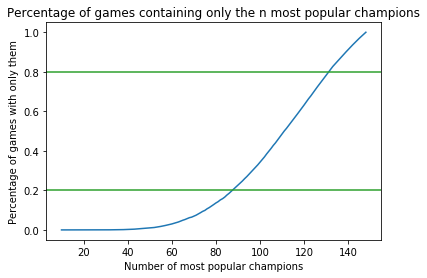

In [11]:
fig, ax = plt.subplots()
percentageWithMostPopChamp_df.plot(x = "Number of most popular champions", 
                                   y = "Percentage of games with only them", 
                                   legend = False, 
                                   ax=ax)
ax.set_title("Percentage of games containing only the n most popular champions")
ax.set_ylabel("Percentage of games with only them")
ax.axhline(y=0.2, color="C2")
ax.axhline(y=0.8, color="C2")

display(percentageWithMostPopChamp_df[percentageWithMostPopChamp_df["Percentage of games with only them"]>=0.2].head(1))
display(percentageWithMostPopChamp_df[percentageWithMostPopChamp_df["Percentage of games with only them"]>=0.5].head(1))
display(percentageWithMostPopChamp_df[percentageWithMostPopChamp_df["Percentage of games with only them"]>=0.8].head(1))

Ce qui est intéressant ici, c'est de constater que retirer quelques champions de l'analyse revient à retirer beaucoup de parties. 

En effet, si on veut :
* 20% des parties, il faut prendre $88 / 148 \approx 59\%$ des champions
* 50% des parties, il faut prendre $111 / 148 \approx 75\%$ des champions
* 80% des parties, il faut prendre $132 / 148 \approx 89\%$ des champions

En y réfléchissant, <i>a posteriori</i>, ça parait logique. Considérons l'ensemble des parties jouées, si on enlève le champion le moins joué, on enlève 1% des parties. Considérons le cas où l'on souhaite enlever un deuxième champion (en supposant qu'il y a indépendance dans le choix des champions) ayant lui aussi une probabilité de présence de 1%. Les deux champions ne seront présents ensemble que dans une partie sur 10 000. Au final, en enlevant deux champions avec une présence de 1%, on enlève 2% des parties.

Si on souhaite à un moment simplifier le problème, retirer des champions ne sera donc vraisemblablement pas une bonne solution.

## 4.4. Taux de victoire par champion

In [12]:
champion_key_list = list(champion_popularity_df.index)
champion_victory_nb_dict = dict.fromkeys(champion_key_list,0)
champion_games_nb_dict = dict.fromkeys(champion_key_list,0)

for index, row in games_df.iterrows():
    if (row["team1_outcome"] == "Win"):
        t = 0
    else:
        t = 1
        
    for p in range(1,5 + 1):
        champion_victory_nb_dict[row["participant_" + str(t * 5 + p) + "_championId"]] += 1
        
    for p in range(1, 10 + 1):
        champion_games_nb_dict[row["participant_" + str(p) + "_championId"]] += 1

champion_winrate_df = pd.DataFrame.from_dict({"victory_nb" : champion_victory_nb_dict, 
                                              "games_nb" : champion_games_nb_dict })
champion_winrate_df.index.name = "champion_key"
champion_winrate_df["winrate"] = champion_winrate_df["victory_nb"] / champion_winrate_df["games_nb"]
#Remarque : l'utilisation de dataframe a été testée pour réaliser cette tâche. 
#Sur 10000 lignes, l'utilisation de dictionnaire est 2 fois plus rapide.

In [13]:
champion_winrate_df.sort_values("winrate", ascending = False)

,victory_nb,games_nb,winrate
champion_key,,,
44,1295,2388,0.542295
136,637,1196,0.532609
121,4089,7725,0.529320
69,4196,7930,0.529130
21,9834,18593,0.528909
427,890,1690,0.526627
421,3781,7195,0.525504
240,1875,3575,0.524476
98,2406,4596,0.523499


## 4.5. Taux de victoire et popularité

In [14]:
champion_board_df = pd.concat([champion_popularity_df,champion_winrate_df],axis = 1)

------------------------
Top 10 winrate champions
------------------------


,count,popularity,champion_id,victory_nb,games_nb,winrate
champion_key,,,,,,
44,2388,0.034635,Taric,1295,2388,0.542295
136,1196,0.017346,AurelionSol,637,1196,0.532609
121,7725,0.112041,Khazix,4089,7725,0.529320
69,7930,0.115014,Cassiopeia,4196,7930,0.529130
21,18593,0.269667,MissFortune,9834,18593,0.528909
427,1690,0.024511,Ivern,890,1690,0.526627
421,7195,0.104354,RekSai,3781,7195,0.525504
240,3575,0.051851,Kled,1875,3575,0.524476
98,4596,0.066659,Shen,2406,4596,0.523499


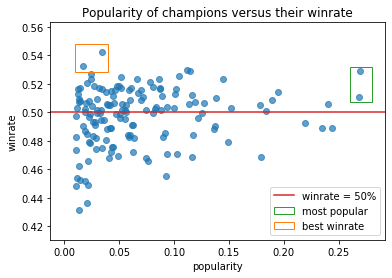

In [15]:
print("------------------------")
print("Top 10 winrate champions")
print("------------------------")
display(champion_board_df.sort_values("winrate", ascending = False).head(10))

fig,ax = plt.subplots(1)
plt.scatter(champion_board_df["popularity"],champion_board_df["winrate"], alpha = 0.7)
plt.xlabel("popularity")
plt.ylabel("winrate")
plt.title("Popularity of champions versus their winrate")

plt.axhline(y=0.5, color = "C3", label = "winrate = 50%")
popular_rect = patches.Rectangle((0.26,0.507),0.02,0.025,
                                 linewidth = 1,
                                 edgecolor = "C2",
                                 facecolor = "none", 
                                 label = "most popular")
ax.add_patch(popular_rect)
best_winrate_rect = patches.Rectangle((0.01,0.528),0.03,0.02,
                                      linewidth = 1,
                                      edgecolor = "C1",
                                      facecolor = "none", 
                                      label = "best winrate")
ax.add_patch(best_winrate_rect)
ax.legend()
plt.show()

Il est intéressant ici de remarquer que :
* les deux champions les plus populaires (entourés en vert) ont un taux de victoire supérieur à 50%.
* pour le reste des champions, on n'observe pas de corrélation claire entre popularité et taux de victoire.
* les deux champions avec les plus hauts taux de victoire sont deux champions peu joués.

On peut vérifier le 2ème point en régréssant "winrate" contre "popularity".

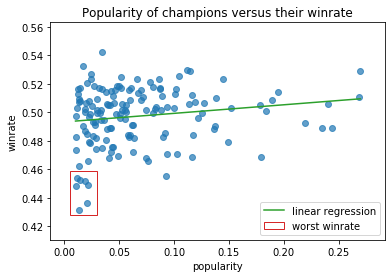

Coefficient of the regression: [0.06016243]


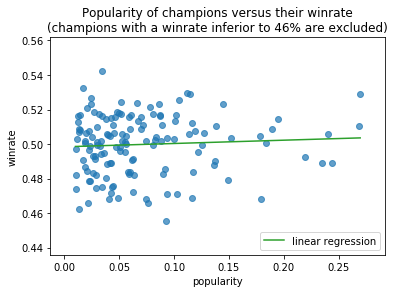

Coefficient of the regression: [0.01911088]

------------------------
Low popularity low winrate champions
------------------------


,count,popularity,champion_id,victory_nb,games_nb,winrate
champion_key,,,,,,
350,1461,0.021190,Yuumi,656,1461,0.449008
113,1423,0.020639,Sejuani,621,1423,0.436402
14,1272,0.018449,Sion,575,1272,0.452044
518,1001,0.014518,Neeko,453,1001,0.452547
268,937,0.013590,Azir,404,937,0.431163
42,820,0.011893,Corki,372,820,0.453659
32,705,0.010225,Amumu,316,705,0.448227


In [16]:
f = LinearRegression()
X = champion_board_df["popularity"].values.reshape(-1,1)
y = champion_board_df["winrate"]
f.fit(X,y)
f.coef_

fig,ax = plt.subplots(1)
plt.scatter(champion_board_df["popularity"],champion_board_df["winrate"], alpha = 0.7)
plt.plot(X,f.intercept_ + f.coef_*X, color = "C2", label = "linear regression")

worst_winrate_rect = patches.Rectangle((0.005,0.428),0.025,0.031,
                                       linewidth = 1,
                                       edgecolor = "C3",
                                       facecolor = "none", 
                                       label = "worst winrate")
ax.add_patch(worst_winrate_rect)

plt.xlabel("popularity")
plt.ylabel("winrate")
plt.title("Popularity of champions versus their winrate")
ax.legend(loc = "lower right")
plt.show()

print("Coefficient of the regression:", f.coef_)

f = LinearRegression()
X = champion_board_df.loc[(champion_board_df["winrate"]>0.46) | (champion_board_df["popularity"]>0.05)]["popularity"].values.reshape(-1,1)
y = champion_board_df.loc[(champion_board_df["winrate"]>0.46) | (champion_board_df["popularity"]>0.05)]["winrate"]
f.fit(X,y)
f.coef_

fig,ax = plt.subplots(1)
plt.scatter(champion_board_df["popularity"].loc[(champion_board_df["winrate"]>0.46) | (champion_board_df["popularity"]>0.05)],
            champion_board_df["winrate"].loc[(champion_board_df["winrate"]>0.46) | (champion_board_df["popularity"]>0.05)], 
            alpha = 0.7)
plt.plot(X,f.intercept_ + f.coef_*X, color = "C2", label = "linear regression")
plt.xlabel("popularity")
plt.ylabel("winrate")
plt.title("Popularity of champions versus their winrate\n(champions with a winrate inferior to 46% are excluded)")
ax.legend(loc = "lower right")
plt.show()

print("Coefficient of the regression:", f.coef_)
print()
print("------------------------")
print("Low popularity low winrate champions")
print("------------------------")
display(champion_board_df.loc[(champion_board_df["winrate"]<=0.46) & (champion_board_df["popularity"]<=0.05)])

On remarque que contrairement à notre première impression, il y a une corrélation légère entre popularité d'un champion et son taux de victoire.

Cette corrélation est très impactée par un groupe de champions peu populaires avec un taux de victoire très faible.

## 4.6. Exploration par rôle

Dans League of Legends, les 5 joueurs de chaque équipe occupent un des cinq rôles suivants :
* Toplaner
* Midlaner
* Jungler
* Ad carry
* Support

Tous les champions ne sont pas jouables sur ces 5 rôles. C'est pourquoi, il est aussi intéressant d'explorer les données conditionnellement à ce rôle.

In [17]:
game_without_NONE_df = games_df.loc[games_df["participant_1_lane"] != "NONE"]
game_without_NONE_n = len(game_without_NONE_df)
df = game_without_NONE_df.copy()

for i in range(1,10+1):
    exec('%s = df.filter(like = "participant_" + str(%s) + "_").filter(regex = "champion|lane|role")' % ("participant_" + str(i),i))
    exec('%s.columns = ["champion_key","role","lane"]' % ("participant_" + str(i)))
    
df = pd.concat([participant_1,
                participant_2,
                participant_3,
                participant_4,
                participant_5,
                participant_6,
                participant_7,
                participant_8,
                participant_9,
                participant_10])
df.pivot_table(index='role',columns='lane',aggfunc='count')

champion_key                            
lane              BOTTOM    JUNGLE   MIDDLE      TOP
role                                                
DUO               1989.0       NaN  23897.0  13311.0
DUO_CARRY       106761.0       NaN   2972.0   1862.0
DUO_SUPPORT     107954.0       NaN   8086.0   2376.0
NONE                 NaN  128027.0      NaN      NaN
SOLO              8390.0       NaN  97267.0  97968.0

On s'attendait à avoir les couples :
* Top, Solo => Toplaner
* Jungle, None => Jungler
* Middle, Solo => Midlaner
* Bottom, Duo_Carry => Ad Carry
* Bottom, Duo_Support => Support

Ces résultats montrent que les prédictions faites par l'éditeur ne sont pas précises (sauf pour le poste de jungler qui a une particularité qui le rend facile à identifier).
Ceci complique l'utilisation de modèles avec l'emplacement du joueur.

Après quelques recherches sur internet, on trouve quelques pistes permettant d'améliorer ces résultats dans les cas litigieux (qui ne rentrent pas dans les catégories précédemment cités) :
* en se basant sur le mapping précédemment présenté
* en se basant sur la popularité des champions par rôle (lorsqu'il n'y a pas d'ambiguïté)
* en se basant sur les habitudes des joueurs (généralement, un joueur occupe un rôle principal, et un secondaire lorsque le matchmaking l'empêche d'avoir son premier rôle)<br>
Source: https://readthedocs.org/projects/riot-api-libraries/downloads/pdf/latest/

A cela on pourrait également ajouter d'autres facteurs qui aideraient à prédire le rôle du joueur :
* le nombre de serviteurs tués
* le nombre de monstres tués
* l'or généré
* les objets achetés
* les autres champions présents et le poste qu'on a prédit pour eux
* ...

Il y a tellement de type d'informations différentes qu'on peut exploiter pour prédire l'emplacement de chaque joueur, que je suis intimement persuadé qu'on peut atteindre une précision dépassant les 99% sur ce problème. Toutefois, cette question pourrait à elle seule faire l'objet d'un projet.



Pour voir à quel point il est nécessaire de faire ce travail si on veut exploiter cette information, regardons si on peut se baser uniquement sur les colonnes "lane" pour distinguer les 4 catégories : Bottom, Jungle, Middle, Top.
(dans un monde semi-parfait, ces valeurs sont correctes). Le cas échéant, on pourrait au moins appliquer notre méthode sur ces quatre catégories, sans faire la distinction entre Ad Carry et Support)

In [18]:
toplane_champion_df = df.loc[df["lane"]=="TOP"][["champion_key","lane"]].groupby(["champion_key"]).count()
toplane_champion_df.rename(columns={'lane':'game_number'}, inplace=True)
toplane_champion_df = toplane_champion_df.sort_values("game_number", ascending = False)
toplane_champion_df["popularity"] = toplane_champion_df["game_number"] / game_without_NONE_n
toplane_champion_df["popularity_rank"] = toplane_champion_df["popularity"].rank(method = 'min', ascending = False)
toplane_champion_df["cumulative_popularity"] = toplane_champion_df["popularity"].cumsum()
toplane_champion_df = pd.merge(toplane_champion_df,
                            champion_df,
                            how="left",
                            on="champion_key")
 
toplane_champion_df

,game_number,popularity,popularity_rank,cumulative_popularity,champion_id
champion_key,,,,,
875,7370,0.122658,1.0,0.122658,Sett
516,5982,0.099557,2.0,0.222215,Ornn
82,5748,0.095663,3.0,0.317878,Mordekaiser
122,5219,0.086859,4.0,0.404737,Darius
114,4451,0.074077,5.0,0.478814,Fiora
24,4219,0.070216,6.0,0.549030,Jax
164,3917,0.065190,7.0,0.614220,Camille
84,3510,0.058416,8.0,0.672636,Akali
92,3419,0.056902,9.0,0.729538,Riven


Les 69 champions les plus joués en toplane sont "acceptables" à ce poste. A partir du 70ème, on a des champions qui sont presque sûrement joués à un autre poste.

Autre surprise, normalement, le cumul des popularités devrait atteindre 2 (puisqu'il y a un toplaner dans chaque équipe. Hors ce n'est pas le cas, c'est un autre indice qui suggère que le champ "lane" n'est pas correct à 100%

Exemple ci-après avec la partie 4364343694 : <br>
Les participants 1, 3 et 9 sont déclarés comme étant en midlane.
Dans les faits, un des trois est en réalité en toplane (en supposant que tous les rôles sont correctements prédits).

In [19]:
games_df.loc[4364343694].filter(like="lane")

participant_1_lane     MIDDLE
participant_2_lane     BOTTOM
participant_3_lane     MIDDLE
participant_4_lane     BOTTOM
participant_5_lane     JUNGLE
participant_6_lane     JUNGLE
participant_7_lane        TOP
participant_8_lane     JUNGLE
participant_9_lane     BOTTOM
participant_10_lane    MIDDLE
Name: 4364343694, dtype: object

## 4.7 Pour aller plus loin

Autre idée que j'aurais aimé investiguer :
* Est-ce que certains champions sont plus efficaces du côté rouge/bleu ?

# 5. Modèles : itération 1

## 5.1. Création du dataset

Dans notre premier modèle, nous voulons prédire l'issue d'une partie à partir de la composition des deux équipes.

Les explications relatives au preprocessing sont détaillées dans les fonctions de preprocessing.

In [20]:
def preprocess_Y(games_df):
    """Réalise le preprocessing de la variable à expliquer
        Input :
            games_df : dataframe contenant la liste des parties
        Output :    
            Dataframe contenant les valeurs : 1 si l'équipe bleue a gagné la partie, 0 sinon
    """ 
    team1_outcome = games_df[["team1_outcome"]]
    team1_outcome = team1_outcome["team1_outcome"].map({"Win": 1, "Fail": 0}) \
                                                    .to_frame() \
                                                    .rename(columns={'team1_outcome': 'outcome'})
    return team1_outcome

In [21]:
team1_y = preprocess_Y(games_df)
team1_y_test = preprocess_Y(games_test_df)

display(team1_y.head())

,outcome
gameId,
4372853992,0
4371569841,1
4363305102,1
4376586295,0
4372794448,1


In [22]:
def preprocess_X_M1(games_df):
    """Réalise le preprocessing des variables explicatives pour notre première itération de modèle
        Input :
            games_df : dataframe contenant la liste des parties
        Output :    
            Dataframe contenant pour chaque partie 2 * 148 variables dummy
            Les 148 premières valent : 1 si le champion avec la champion_key correspondant est présent dans l'équipe bleue, 0 sinon
            Les 148 suivantes valent : 1 si le champion avec la champion_key correspondant est présent dans l'équipe rouge, 0 sinon
    """ 
    df = games_df.filter(like = "champion")
    
    participant_1_champion_key = df[["participant_1_championId"]].rename(columns={"participant_1_championId" : "champion_key"})
    participant_2_champion_key = df[["participant_2_championId"]].rename(columns={"participant_2_championId" : "champion_key"})
    participant_3_champion_key = df[["participant_3_championId"]].rename(columns={"participant_3_championId" : "champion_key"})
    participant_4_champion_key = df[["participant_4_championId"]].rename(columns={"participant_4_championId" : "champion_key"})
    participant_5_champion_key = df[["participant_5_championId"]].rename(columns={"participant_5_championId" : "champion_key"})
    participant_6_champion_key = df[["participant_6_championId"]].rename(columns={"participant_6_championId" : "champion_key"})
    participant_7_champion_key = df[["participant_7_championId"]].rename(columns={"participant_7_championId" : "champion_key"})
    participant_8_champion_key = df[["participant_8_championId"]].rename(columns={"participant_8_championId" : "champion_key"})
    participant_9_champion_key = df[["participant_9_championId"]].rename(columns={"participant_9_championId" : "champion_key"})
    participant_10_champion_key = df[["participant_10_championId"]].rename(columns={"participant_10_championId" : "champion_key"})
    
    team1 = pd.concat([participant_1_champion_key, 
                       participant_2_champion_key,
                       participant_3_champion_key,
                       participant_4_champion_key,
                       participant_5_champion_key])
    team1 = pd.get_dummies(team1["champion_key"]).groupby(level="gameId").sum().add_prefix('team1_')
    
    team2 = pd.concat([participant_6_champion_key, 
                       participant_7_champion_key,
                       participant_8_champion_key,
                       participant_9_champion_key,
                       participant_10_champion_key])
    team2 = pd.get_dummies(team2["champion_key"]).groupby(level="gameId").sum().add_prefix('team2_')

    return pd.merge(team1, team2, left_index=True, right_index=True)



In [23]:
X_M1 = preprocess_X_M1(games_df)
X_test_M1 = preprocess_X_M1(games_test_df)

display(X_M1.head())

,team1_1,team1_2,team1_3,team1_4,team1_5,team1_6,team1_7,team1_8,team1_9,team1_10,...,team2_429,team2_432,team2_497,team2_498,team2_516,team2_517,team2_518,team2_523,team2_555,team2_875
gameId,,,,,,,,,,,,,,,,,,,,,
4361282723,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4361282759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4361282784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4361282791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4361282961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5.2. SVM

### 5.2.1. Ensemble des parties

On implémente un SVM basé sur l'ensemble des parties.

------------------------------
Prediction on the training set
------------------------------


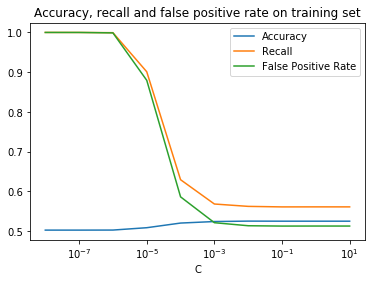

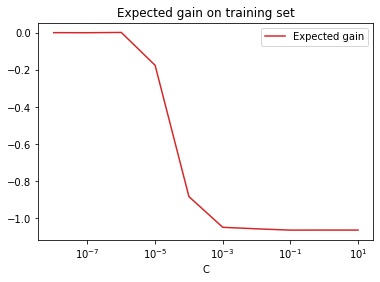

------------------------------
Prediction on the testing set
------------------------------


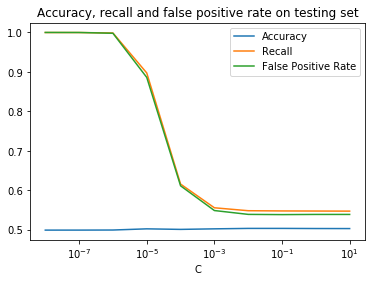

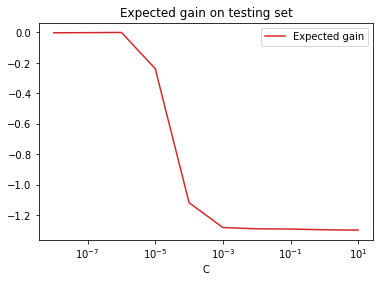

--------------------------
With C = 10**-7
Accuracy: [0.5035741]
Recall: [0.54839084]
False positive rate: [0.99988414]
Expected gain: [-0.00139227]
--------------------------
With C = 10**-2
Accuracy: [0.5035741]
Recall: [0.54839084]
False positive rate: [0.53910323]
Expected gain: [-1.28959276]


In [24]:
C = np.arange(-8, 2, 1)
C = np.float_power(10, C)

tn, fp, fn, tp, accuracy, recall, fp_rate, gain = [np.zeros(len(C)) for _ in range(8)]

#SVM with prediction on the training set
print('------------------------------')
print('Prediction on the training set')
print('------------------------------')

for i in np.arange(len(C)):
    svm = LinearSVC(C=C[i], dual=False).fit(X_M1,team1_y["outcome"])
    team1_y_predict = svm.predict(X_M1)
    confusion_matrix_test = confusion_matrix(team1_y,team1_y_predict)
    tp[i], fn[i], fp[i], tn[i] = confusion_matrix_test.ravel()
    accuracy[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    fp_rate[i] = fp[i] / (tn[i] + fp[i]) 
    gain[i] = (- 18 * fn[i] + 12 * tn[i])/(tp[i] + fp[i] + fn[i] + tn[i]) #Gain espéré 

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, accuracy, label = "Accuracy")
ax.plot(C, recall, label = "Recall")
ax.plot(C, fp_rate, label = "False Positive Rate")
ax.legend()
ax.set_xscale('log')
ax.set_title('Accuracy, recall and false positive rate on training set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C,gain, label = "Expected gain", color = "C3")
ax.legend()
ax.set_xscale('log')
ax.set_title('Expected gain on training set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

#SVM with prediction on the testing set
print('------------------------------')
print('Prediction on the testing set')
print('------------------------------')

for i in np.arange(len(C)):
    svm = LinearSVC(C=C[i], dual=False).fit(X_M1,team1_y["outcome"])
    team1_y_test_predict = svm.predict(X_test_M1)
    confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
    tp[i], fn[i], fp[i], tn[i] = confusion_matrix_test.ravel()
    accuracy[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    fp_rate[i] = fp[i] / (tn[i] + fp[i])    
    gain[i] = (- 18 * fn[i] + 12 * tn[i])/(tp[i] + fp[i] + fn[i] + tn[i]) #Gain espéré     
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, accuracy, label = "Accuracy")
ax.plot(C, recall, label = "Recall")
ax.plot(C, fp_rate, label = "False Positive Rate")
ax.legend()
ax.set_xscale('log')
ax.set_title('Accuracy, recall and false positive rate on testing set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C,gain, label = "Expected gain", color = "C3")
ax.legend()
ax.set_xscale('log')
ax.set_title('Expected gain on testing set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

print('--------------------------')
print("With C = 10**-7")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-7)])
print("Expected gain:",gain[np.where(C == 10**-7)])
print('--------------------------')
print("With C = 10**-2")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-2)])
print("Expected gain:",gain[np.where(C == 10**-2)])

On remarque que notre premier essai ne donne aucun résultat :
* la précision est très proche de 0.5 quel que soit C.
* l'espérance de gain avec notre approche est négative quel que soit C.
* pour C faible, le classifieur classe quasiment toutes les parties comme des victoires.

### 5.2.2. Parties sans Sett

Comme expliqué plus (en 2.2.), l'arrivée d'un nouveau champion Sett pourrait éventuellement perturbé nos résultats.

Essayons d'appliquer notre SVM aux parties où ce champion n'est pas présent.

In [25]:
def remove_sett_games(games_df):
    """Retire les parties où le champion Sett est joué"""     
    df = games_df
    df = df[df.participant_1_championId != 875]
    df = df[df.participant_2_championId != 875]
    df = df[df.participant_3_championId != 875]
    df = df[df.participant_4_championId != 875]
    df = df[df.participant_5_championId != 875]
    df = df[df.participant_6_championId != 875]
    df = df[df.participant_7_championId != 875]
    df = df[df.participant_8_championId != 875]
    df = df[df.participant_9_championId != 875]
    df = df[df.participant_10_championId != 875]
    return df

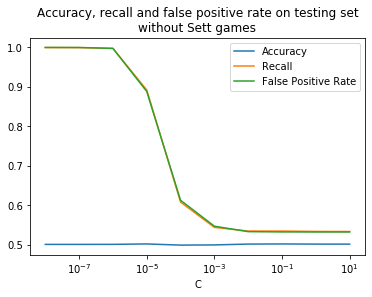

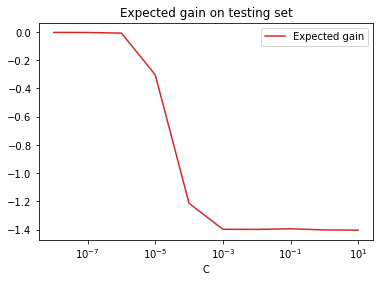

--------------------------
With C = 10**-7
Accuracy: [0.50151495]
Recall: [0.53454086]
False positive rate: [0.99957741]
Expected gain: [-0.0037972]
--------------------------
With C = 10**-2
Accuracy: [0.50151495]
Recall: [0.53454086]
False positive rate: [0.53303282]
Expected gain: [-1.39863582]


In [26]:
games_df_without_sett = remove_sett_games(games_df)
games_test_df_without_sett = remove_sett_games(games_test_df)

team1_y_without_sett = preprocess_Y(games_df_without_sett)
team1_y_test_without_sett = preprocess_Y(games_test_df_without_sett)
X_without_sett_M1 = preprocess_X_M1(games_df_without_sett)
X_test_without_sett__M1 = preprocess_X_M1(games_test_df_without_sett)


#SVM with prediction on the testing set
for i in np.arange(len(C)):
    svm = LinearSVC(C=C[i], dual=False).fit(X_without_sett_M1,team1_y_without_sett["outcome"])
    team1_y_test_predict = svm.predict(X_test_without_sett__M1)
    confusion_matrix_test = confusion_matrix(team1_y_test_without_sett,team1_y_test_predict)
    tp[i], fn[i], fp[i], tn[i] = confusion_matrix_test.ravel()
    accuracy[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    fp_rate[i] = fp[i] / (tn[i] + fp[i])    
    gain[i] = (- 18 * fn[i] + 12 * tn[i])/(tp[i] + fp[i] + fn[i] + tn[i]) #Gain espéré     

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, accuracy, label = "Accuracy")
ax.plot(C, recall, label = "Recall")
ax.plot(C, fp_rate, label = "False Positive Rate")
ax.legend()
ax.set_xscale('log')
ax.set_title('Accuracy, recall and false positive rate on testing set\nwithout Sett games')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C,gain, label = "Expected gain", color = "C3")
ax.legend()
ax.set_xscale('log')
ax.set_title('Expected gain on testing set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

print('--------------------------')
print("With C = 10**-7")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-7)])
print("Expected gain:",gain[np.where(C == 10**-7)])
print('--------------------------')
print("With C = 10**-2")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-2)])
print("Expected gain:",gain[np.where(C == 10**-2)])

On observe aucune amélioration de nos résultats

## 5.3. Trees

In [27]:
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_M1, team1_y["outcome"])
team1_y_test_predict = dtree.predict(X_test_M1)
confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
tp, fn, fp, tn = confusion_matrix_test.ravel()
accuracy = tp / (tp + fp)
gain = (- 18 * fn + 12 * tn)/(tp + fp + fn + tn)

print("Accuracy:",accuracy)
print("Expected gain:",gain)

Accuracy: 0.4950884086444008
Expected gain: -1.5471632439958232


## 5.4. KNN

In [28]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn = knn.fit(X_M1, team1_y["outcome"])
team1_y_test_predict = knn.predict(X_test_M1)
confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
tp, fn, fp, tn = confusion_matrix_test.ravel()
accuracy = tp / (tp + fp)
gain = (- 18 * fn + 12 * tn)/(tp + fp + fn + tn)

print("Accuracy:",accuracy)
print("Expected gain:",gain)

Accuracy: 0.4973041183893541
Expected gain: -1.5029585798816567


## 5.5. Conclusion Modèle de Type 1

Après cette première analyse, on voit que la présence ou non d'un personnage n'est <i>a priori</i> pas suffisante pour déterminer l'issue d'une partie. Il me semble peu probable qu'une régression logistique, un random forest ou une autre méthode soit substantiellement meilleure.

On va donc tenter d'améliorer nos modèles en ajoutant de nouvelles features

# 6. Modèles : itération 2

## 6.1. Création d'un dataset

Cette fois-ci, on va calculer différentes features issues des champions sélectionnés, de leur taux de victoire et de leur popularité.
(Le détail des modifications est expliqué dans la fonction "preprocess_X_M2")

In [29]:
def select_wr_quartile(x, wr_q):
    """Retourne le quantile de taux de victoire auquel le champion appartient"""
    if x < wr_q[0.1]:
        return "wr_q1"
    elif x < wr_q[0.5]:
        return "wr_q2"
    elif x < wr_q[0.9]:
        return "wr_q3"
    else:
        return 'wr_q4'

def select_pop_quartile(x, pop_q):
    """Retourne le quantile de popularité auquel le champion appartient"""
    if x < pop_q[0.1]:
        return "pop_q4"
    elif x < pop_q[0.5]:
        return "pop_q3"
    elif x < pop_q[0.9]:
        return "pop_q2"
    else:
        return 'pop_q1'
    
def preprocess_X_M2(games_df):   
    """Réalise le preprocessing des variables explicatives pour notre seconde itération de modèle
        Input :
            games_df : dataframe contenant la liste des parties
        Output :    
            Dataframe contenant pour chaque partie 2 * 12 variables :
                - Colonne winrate_sum : contient la somme des winrates des champions de l'équipe
                - Colonne winrate_prod : contient le produit des winrates des champions de l'équipe
                - Colonne winrate_more_than_50 : contient le nombre de champions de l'équipe ayant un winrate supérieur à 50%
                - Colonnes winrate_q : contient le nombre de champions de l'équipe appartenant à un quantile de winrate
                - Colonne popularity_sum : contient la somme des popularités des champions de l'équipe
                - Colonnes popularity_q : contient le nombre de champions de l'équipe appartenant à un quantile de popularité
    """ 

    df = games_df.filter(like = "champion")

    #Création de colonnes liées au taux de victoire
    winrate_dict = champion_board_df["winrate"].to_dict()

    participant_1_champion_winrate = df["participant_1_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_1_championId" : "winrate"})
    participant_2_champion_winrate = df["participant_2_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_2_championId" : "winrate"})
    participant_3_champion_winrate = df["participant_3_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_3_championId" : "winrate"})
    participant_4_champion_winrate = df["participant_4_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_4_championId" : "winrate"})
    participant_5_champion_winrate = df["participant_5_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_5_championId" : "winrate"})
    participant_6_champion_winrate = df["participant_6_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_6_championId" : "winrate"})
    participant_7_champion_winrate = df["participant_7_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_7_championId" : "winrate"})
    participant_8_champion_winrate = df["participant_8_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_8_championId" : "winrate"})
    participant_9_champion_winrate = df["participant_9_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_9_championId" : "winrate"})
    participant_10_champion_winrate = df["participant_10_championId"].map(winrate_dict).to_frame() \
                                        .rename(columns={"participant_10_championId" : "winrate"})    

    team1_winrate = pd.concat([participant_1_champion_winrate,
                               participant_2_champion_winrate,
                               participant_3_champion_winrate,
                               participant_4_champion_winrate,
                               participant_5_champion_winrate])
    team2_winrate = pd.concat([participant_6_champion_winrate,
                               participant_7_champion_winrate,
                               participant_8_champion_winrate,
                               participant_9_champion_winrate,
                               participant_10_champion_winrate])

    #Création d'une colonne avec la somme des taux de victoires des champions de chaque équipe
    team1_winrate_sum = team1_winrate.groupby(level="gameId").sum().rename(columns={"winrate" : "winrate_sum"})
    team2_winrate_sum = team2_winrate.groupby(level="gameId").sum().rename(columns={"winrate" : "winrate_sum"})

    #Création d'une colonne avec le produit des taux de victoires des champions de chaque équipe
    team1_winrate_prod = team1_winrate.groupby(level="gameId").prod().rename(columns={"winrate" : "winrate_prod"})
    team2_winrate_prod = team2_winrate.groupby(level="gameId").prod().rename(columns={"winrate" : "winrate_prod"})

    #Création d'une colonne avec le nombre de champions dans l'équipe avec un winrate supérieur à 50%
    team1_winrate_more_than_50 = team1_winrate["winrate"].apply(lambda x : int(x >=0.5)) \
                                                .groupby(level="gameId").sum().to_frame() \
                                                .rename(columns={"winrate" : "winrate_more_than_50"})
    team2_winrate_more_than_50 = team2_winrate["winrate"].apply(lambda x : int(x >=0.5)) \
                                                .groupby(level="gameId").sum().to_frame() \
                                                .rename(columns={"winrate" : "winrate_more_than_50"})

    #Création d'une colonne avec le nombre de champions dans l'équipe appartenant à chaque quartile de taux de victoire
    winrate_q = champion_board_df["winrate"].quantile([0.1,0.5,0.9])

    team1_winrate_q = pd.get_dummies(team1_winrate["winrate"].apply(lambda x : select_wr_quartile(x, winrate_q))) \
                                        .groupby(level="gameId").sum().rename(columns={"winrate" : "winrate_q"})
    team2_winrate_q = pd.get_dummies(team2_winrate["winrate"].apply(lambda x : select_wr_quartile(x, winrate_q))) \
                                        .groupby(level="gameId").sum().rename(columns={"winrate" : "winrate_q"})

    
    #Création de colonnes liées à la popularité des champions
    popularity_dict = champion_board_df["popularity"].to_dict()

    participant_1_champion_popularity = df["participant_1_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_1_championId" : "popularity"})
    participant_2_champion_popularity = df["participant_2_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_2_championId" : "popularity"})
    participant_3_champion_popularity = df["participant_3_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_3_championId" : "popularity"})
    participant_4_champion_popularity = df["participant_4_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_4_championId" : "popularity"})
    participant_5_champion_popularity = df["participant_5_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_5_championId" : "popularity"})
    participant_6_champion_popularity = df["participant_6_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_6_championId" : "popularity"})
    participant_7_champion_popularity = df["participant_7_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_7_championId" : "popularity"})
    participant_8_champion_popularity = df["participant_8_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_8_championId" : "popularity"})
    participant_9_champion_popularity = df["participant_9_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_9_championId" : "popularity"})
    participant_10_champion_popularity = df["participant_10_championId"].map(popularity_dict).to_frame() \
                                            .rename(columns={"participant_10_championId" : "popularity"})    

    team1_popularity = pd.concat([participant_1_champion_popularity,
                                  participant_2_champion_popularity,
                                  participant_3_champion_popularity,
                                  participant_4_champion_popularity,
                                  participant_5_champion_popularity])
    team2_popularity = pd.concat([participant_6_champion_popularity,
                                  participant_7_champion_popularity,
                                  participant_8_champion_popularity,
                                  participant_9_champion_popularity,
                                  participant_10_champion_popularity])
    
    #Création d'une colonne avec la somme des popularité des champions de chaque équipe
    team1_popularity_sum = team1_popularity.groupby(level="gameId").sum().rename(columns={"popularity" : "popularity_sum"})
    team2_popularity_sum = team2_popularity.groupby(level="gameId").sum().rename(columns={"popularity" : "popularity_sum"})

    #Création d'une colonne avec le nombre de champions dans l'équipe appartenant à chaque quartile de popularité
    popularity_q = champion_board_df["popularity"].quantile([0.1,0.5,0.9])

    team1_popularity_q = pd.get_dummies(team1_popularity["popularity"].apply(lambda x : select_pop_quartile(x, popularity_q))) \
                                        .groupby(level="gameId").sum().rename(columns={"popularity" : "popularity_popularity_q"})
    team2_popularity_q = pd.get_dummies(team2_popularity["popularity"].apply(lambda x : select_pop_quartile(x, popularity_q))) \
                                        .groupby(level="gameId").sum().rename(columns={"popularity" : "popularity_popularity_q"})
    
    
    #Jointure
    team1 = team1_winrate_sum.join(team1_winrate_more_than_50) \
                             .join(team1_winrate_prod) \
                             .join(team1_winrate_q) \
                             .join(team1_popularity_sum) \
                             .join(team1_popularity_q) \
                             .add_prefix('team1_')
    
    team2 = team2_winrate_sum.join(team2_winrate_more_than_50) \
                             .join(team2_winrate_prod) \
                             .join(team2_winrate_q) \
                             .join(team2_popularity_sum) \
                             .join(team2_popularity_q) \
                             .add_prefix('team2_')    

    return team1.join(team2)


In [30]:
X_M2 = preprocess_X_M2(games_df)
X_test_M2 = preprocess_X_M2(games_test_df)

display(X_M2.head())

,team1_winrate_sum,team1_winrate_more_than_50,team1_winrate_prod,team1_wr_q1,team1_wr_q2,team1_wr_q3,team1_wr_q4,team1_popularity_sum,team1_pop_q1,team1_pop_q2,...,team2_winrate_prod,team2_wr_q1,team2_wr_q2,team2_wr_q3,team2_wr_q4,team2_popularity_sum,team2_pop_q1,team2_pop_q2,team2_pop_q3,team2_pop_q4
gameId,,,,,,,,,,,,,,,,,,,,,
4361282723,2.529467,4,0.033124,0,1,4,0,0.584992,1,3,...,0.031699,0,2,2,1,0.808218,2,3,0,0
4361282759,2.486507,3,0.030348,0,2,3,0,0.457635,0,4,...,0.029232,0,3,1,1,0.433646,1,3,1,0
4361282784,2.494072,3,0.030671,1,1,2,1,0.610272,2,1,...,0.033363,0,2,3,0,0.252292,0,2,3,0
4361282791,2.477044,2,0.029823,0,3,2,0,0.672898,1,4,...,0.030638,0,2,3,0,0.348495,1,1,3,0
4361282961,2.521146,4,0.032516,0,1,3,1,0.383680,1,1,...,0.030498,1,1,2,1,0.576101,3,0,1,1


In [31]:
scaler = Normalizer().fit(X_M2)
X_M2_normalized = pd.DataFrame(scaler.transform(X_M2), columns = X_M2.columns)
X_test_M2_normalized = pd.DataFrame(scaler.transform(X_test_M2), columns = X_test_M2.columns)

## 6.2. SVM

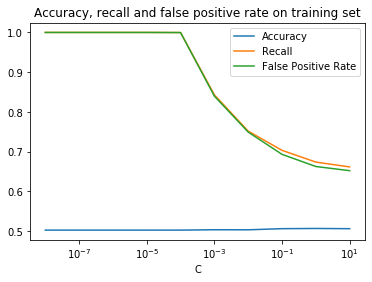

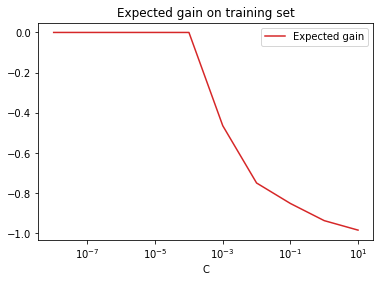

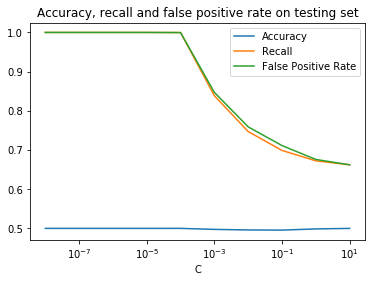

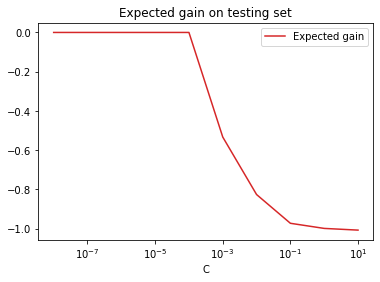

--------------------------
With C = 10**-7
Accuracy: [0.49533719]
Recall: [0.74671779]
False positive rate: [1.]
Expected gain: [0.]
--------------------------
With C = 10**-2
Accuracy: [0.49533719]
Recall: [0.74671779]
False positive rate: [0.75866064]
Expected gain: [-0.82631396]


In [32]:
tn, fp, fn, tp, accuracy, recall, fp_rate, gain = [np.zeros(len(C)) for _ in range(8)]

#SVM with prediction on the training set
for i in np.arange(len(C)):
    svm = LinearSVC(C=C[i], dual=False).fit(X_M2_normalized,team1_y["outcome"])
    team1_y_predict = svm.predict(X_M2_normalized)
    confusion_matrix_test = confusion_matrix(team1_y,team1_y_predict)
    tp[i], fn[i], fp[i], tn[i] = confusion_matrix_test.ravel()
    accuracy[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    fp_rate[i] = fp[i] / (tn[i] + fp[i])    
    gain[i] = (- 18 * fn[i] + 12 * tn[i])/(tp[i] + fp[i] + fn[i] + tn[i]) #Gain espéré 
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, accuracy, label = "Accuracy")
ax.plot(C, recall, label = "Recall")
ax.plot(C, fp_rate, label = "False Positive Rate")
ax.legend()
ax.set_xscale('log')
ax.set_title('Accuracy, recall and false positive rate on training set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C,gain, label = "Expected gain", color = "C3")
ax.legend()
ax.set_xscale('log')
ax.set_title('Expected gain on training set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()


#SVM with prediction on the testing set
for i in np.arange(len(C)):
    svm = LinearSVC(C=C[i], dual=False).fit(X_M2_normalized,team1_y["outcome"])
    team1_y_test_predict = svm.predict(X_test_M2_normalized)
    confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
    tp[i], fn[i], fp[i], tn[i] = confusion_matrix_test.ravel()
    accuracy[i] = tp[i] / (tp[i] + fp[i])
    recall[i] = tp[i] / (tp[i] + fn[i])
    fp_rate[i] = fp[i] / (tn[i] + fp[i])    
    gain[i] = (- 18 * fn[i] + 12 * tn[i])/(tp[i] + fp[i] + fn[i] + tn[i]) #Gain espéré     

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C, accuracy, label = "Accuracy")
ax.plot(C, recall, label = "Recall")
ax.plot(C, fp_rate, label = "False Positive Rate")
ax.legend()
ax.set_xscale('log')
ax.set_title('Accuracy, recall and false positive rate on testing set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(C,gain, label = "Expected gain", color = "C3")
ax.legend()
ax.set_xscale('log')
ax.set_title('Expected gain on testing set')
ax.set_xlabel('C')
ax.set_ylabel('')
plt.show()

print('--------------------------')
print("With C = 10**-7")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-7)])
print("Expected gain:",gain[np.where(C == 10**-7)])
print('--------------------------')
print("With C = 10**-2")
print("Accuracy:",accuracy[np.where(C == 10**-2)])
print("Recall:",recall[np.where(C == 10**-2)])
print("False positive rate:",fp_rate[np.where(C == 10**-2)])
print("Expected gain:",gain[np.where(C == 10**-2)])

In [33]:
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_M2_normalized, team1_y["outcome"])
team1_y_test_predict = dtree.predict(X_test_M2_normalized)
confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
tp, fn, fp, tn = confusion_matrix_test.ravel()
confusion_matrix_test = confusion_matrix(team1_y_test,team1_y_test_predict)
tp, fn, fp, tn = confusion_matrix_test.ravel()
accuracy = tp / (tp + fp)
gain = (- 18 * fn + 12 * tn)/(tp + fp + fn + tn)

print("Accuracy:",accuracy)
print("Expected gain:",gain)

Accuracy: 0.4967816091954023
Expected gain: -1.5137486947441698


## 6.3. Conclusion Modèle de Type 2

On remarque que les résultats obtenus ne sont pas meilleurs.

# 7. Conclusion 

## 7.1. Résultats

Notre tentative de prédiction de l'issue d'une partie de League of Legends basée uniquement sur la composition de l'équipe est un échec. Toutefois, cela ne veut pas dire que notre travail est un échec pour autant.

En effet, ce résultat est finalement rassurant. Cela signifie que la composition de l'équipe n'est pas si importante qu'on pourrait le penser et qu'il y a d'autres facteurs qui rentrent en compte dans le résultat d'une partie.



## 7.2. Améliorations

1) Intégrer les performances individuelles des joueurs

Plutôt que d'utiliser uniquement les données des champions, on pourrait ajouter des variables liées à la maitrise du champion par chaque joueur. (Cette information est disponible lors de la phase de sélection des champions.)

Par exemple, un joueur qui a 60% de taux de victoire avec un champion (quel qu'il soit) a plus de chance de gagner qu'un joueur joueur qui a 40% sur son champion.

2) Intégrer le rôle et la lane

Corriger les données concernant les champions joués sur les différentes lanes pourrait également aider. Un champion donné est rarement fort à tous les postes.

3) Choisir un patch avec une meta (Most Effective Tactic Available) plus propice à cette analyse

Actuellement, beaucoup de champions sont jouables sur beaucoup de lanes. Ce n'est pas toujours le cas. Parfois, seuls 5 à 10 champions sont viables sur certaines lanes.
